## Czy klient zostnaie w banku?

### Cel projektu:

* wyznaczyć wartości, które wpływają na decyzję klienta odnośnie zmiany banku
* napisać model, przewidujący prawdopodobieństwo podjęcia decyzji o zmianie banku

In [539]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from scipy.stats import skew
from scipy.cluster.hierarchy import dendrogram, linkage
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

Wgrywamy dane i usuwamy dwie ostatnie kolumny, jak było napisane w opisie zestawu danych.

In [540]:
df = pd.read_csv('./BankChurners.csv', nrows=1) 
columns = df.columns.tolist() 
cols_to_use = columns[:len(columns)-2] 
df = pd.read_csv('./BankChurners.csv', usecols=cols_to_use)
df.tail()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
10122,772366833,Existing Customer,50,M,2,Graduate,Single,$40K - $60K,Blue,40,...,2,3,4003.0,1851,2152.0,0.703,15476,117,0.857,0.462
10123,710638233,Attrited Customer,41,M,2,Unknown,Divorced,$40K - $60K,Blue,25,...,2,3,4277.0,2186,2091.0,0.804,8764,69,0.683,0.511
10124,716506083,Attrited Customer,44,F,1,High School,Married,Less than $40K,Blue,36,...,3,4,5409.0,0,5409.0,0.819,10291,60,0.818,0.000
10125,717406983,Attrited Customer,30,M,2,Graduate,Unknown,$40K - $60K,Blue,36,...,3,3,5281.0,0,5281.0,0.535,8395,62,0.722,0.000
10126,714337233,Attrited Customer,43,F,2,Graduate,Married,Less than $40K,Silver,25,...,2,4,10388.0,1961,8427.0,0.703,10294,61,0.649,0.189


In [541]:
df.isna().head()
df.isna().sum()

CLIENTNUM                   0
Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

Jak widać w tym zestawie danych nie ma warości zerowych. Sprawdzamy to, bo większość algorytmów i bibliotek może nie działać z brakującymi wartościami.

Spójrzmy na wykres kołowy.

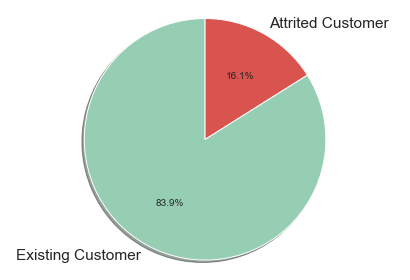

In [542]:
def percent_of_customers(column, value):
    count=0
    for row in df[column]:
        if row==value:
            count+=1
    existing=count/len(df[column])
    return existing
colors=['#96CEB4','#D9534F']
my_data=[percent_of_customers('Attrition_Flag','Existing Customer'),
        percent_of_customers('Attrition_Flag','Attrited Customer')]
my_labels='Existing Customer','Attrited Customer'
fig1, ax1=plt.subplots()
ax1.pie(my_data,labels=my_labels,colors=colors,autopct='%1.1f%%',shadow=True, startangle=90)

ax1.axis('equal')
plt.tight_layout()
plt.show()


Z wykresu wynika, że 16,1% klientów zmieniło bank. Ale to nie dużo w porównaniu do tych, które zostały.

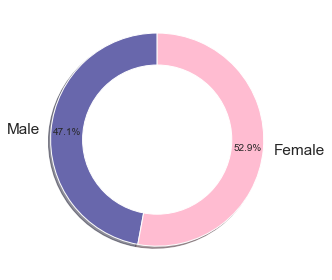

In [543]:
my_data_1=(percent_of_customers('Gender','M'),percent_of_customers('Gender','F'))
my_labels_1="Male","Female"
colors_gender=['#6867AC','#FFBCD1']
plt.pie(my_data_1, colors = colors_gender,
         labels=my_labels_1, autopct='%1.1f%%', startangle=90, pctdistance=0.85,shadow=True)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax1.axis('equal')  
plt.tight_layout()
plt.show()

Z wykresu kołowego widać, że większość klientów, to kobiety.

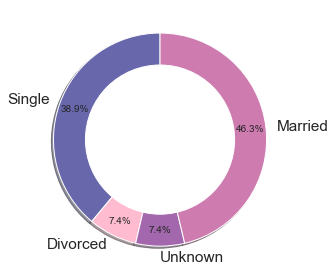

In [544]:
my_data_2=(percent_of_customers('Marital_Status','Single'),percent_of_customers('Marital_Status','Divorced'),
           percent_of_customers('Marital_Status','Unknown'),percent_of_customers('Marital_Status','Married'))
my_labels_2="Single","Divorced","Unknown","Married"
colors_wife=['#6867AC','#FFBCD1','#A267AC','#CE7BB0']
plt.pie(my_data_2, colors = colors_wife,
         labels=my_labels_2, autopct='%1.1f%%', startangle=90, pctdistance=0.85,shadow=True)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax1.axis('equal')  
plt.tight_layout()
plt.show()

Wykres przedstawia rozdzielenie klientów na grupy według stanu cywilnego. Jak widać, w większości mają partnera.

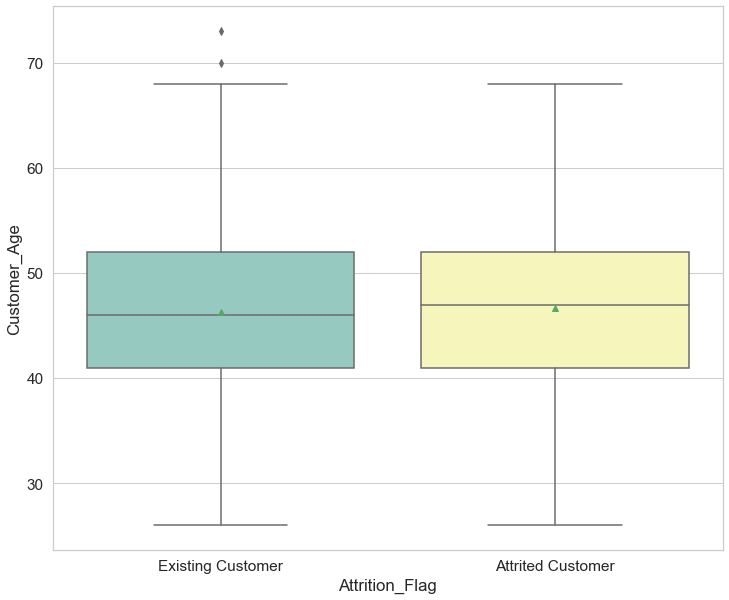

In [597]:
plt.figure(figsize=(12,10))
sns.set_style("whitegrid")
sns.boxplot(x='Attrition_Flag',y='Customer_Age', data=df, showmeans=True, palette='Set3')
plt.show()

Powyższy wykres przedstawia jak wyglądają dane według wieku i zmiany banku. Stosuję wykres pudełkowy żeby wyznaczyć czy są wartości odstające.

Są wartości odstające w obecnych klientach banku, ale nie będę ich usuwała.

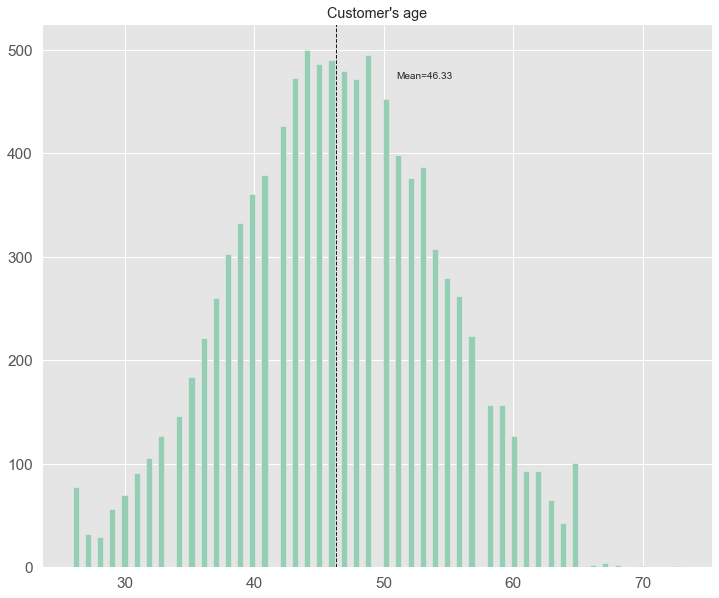

Skośność wynosi: -0.03 


In [599]:
age=df['Customer_Age']
plt.style.use('ggplot')
plt.figure(figsize=(12,10))
plt.hist(age, bins=100, color='#96CEB4')
plt.title("Customer's age")
plt.axvline(age.mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim=plt.ylim()
plt.text(age.mean()*1.1, max_ylim*0.9,'Mean={:.2f}'.format(age.mean()))
plt.show()
print("Skośność wynosi: {:.2f} ".format(skew(age)))

Powyższy wykres przedstawia histogram pokazujący jaki rozkład mają wartości w kolumnie wiek.
Ten histogram jest lekko lewoskośny, bo skośność jest ujemna, ale bardzo bliska zera.
Lewostronność oznacza, że prawy ogon jest przedłużony, czyli w tym przypadku będzie więcej osób starszych.

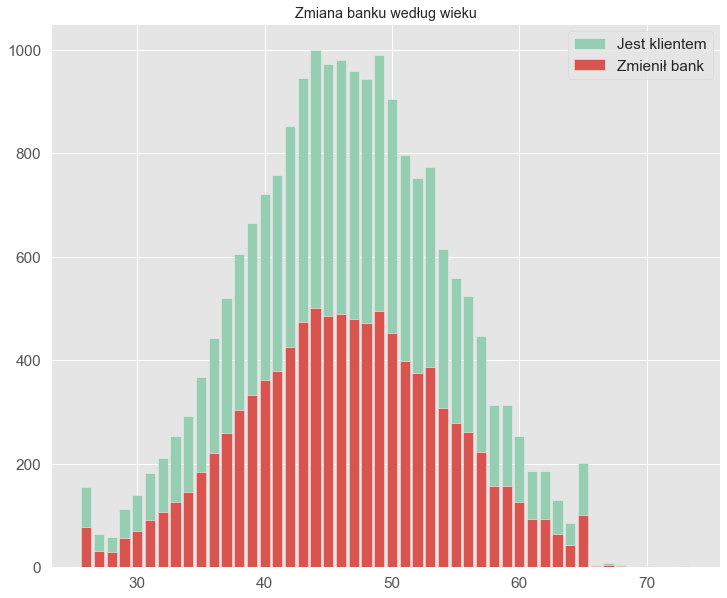

In [546]:
#Histograms

age=df['Customer_Age']
age_existing=pd.DataFrame((df.assign(A=(df["Attrition_Flag"]=='Existing Customer')).groupby(['Customer_Age'])['A'].agg(
   [('existing','size')]).reset_index()))
age_attrited=pd.DataFrame((df.assign(A=(df["Attrition_Flag"]=='Attrited Customer')).groupby(['Customer_Age'])['A'].agg(
   [('attrited','size')]).reset_index()))
plt.figure(figsize=(12,10))
plt.bar(age_existing['Customer_Age'], age_existing['existing'], label="Jest klientem",bottom=age_attrited['attrited'],color='#96CEB4')
plt.bar(age_attrited['Customer_Age'], age_attrited['attrited'], label="Zmienił bank", color='#D9534F')
plt.title("Zmiana banku według wieku")
plt.legend()
plt.show()

Na powyższym wykresie przedstawiono dwa histogramy. Jeden z klientami, którzy korzystają z usług bank, a którzy zmienili bank. Jak widać, nie różnią się za bardzo tylko wysokością. 

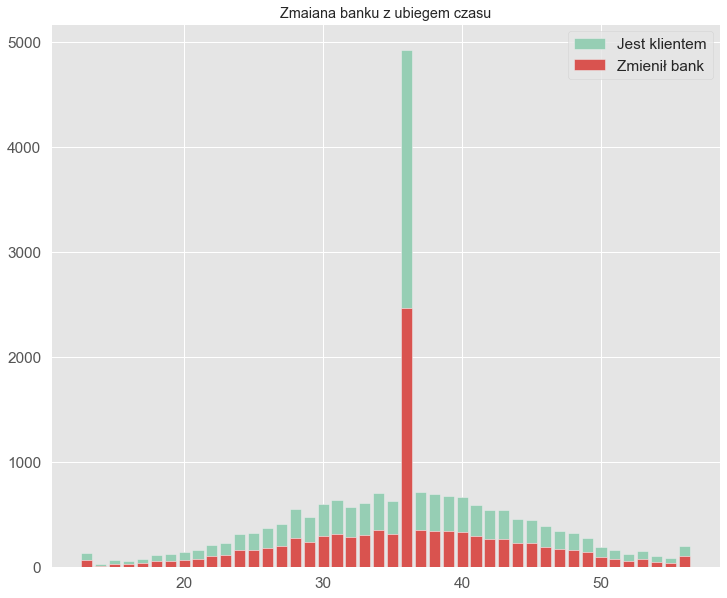

In [547]:
month_on_book=df['Months_on_book']
month_existing=pd.DataFrame((df.assign(A=(df["Attrition_Flag"]=='Existing Customer')).groupby(['Months_on_book'])['A'].agg(
   [('existing','size')]).reset_index()))
month_attrited=pd.DataFrame((df.assign(A=(df["Attrition_Flag"]=='Attrited Customer')).groupby(['Months_on_book'])['A'].agg(
   [('attrited','size')]).reset_index()))
plt.figure(figsize=(12,10))
plt.bar(month_existing['Months_on_book'], month_existing['existing'], label="Jest klientem",bottom=month_attrited['attrited'],color='#96CEB4')
plt.bar(month_attrited['Months_on_book'], month_attrited['attrited'], label="Zmienił bank", color='#D9534F')
plt.title("Zmaiana banku z ubiegem czasu")
plt.legend()
plt.show()

Z wykresu nie widać jakiejś tendecji zmiany banku opartej na ilości miesięcy w tym banku.

In [548]:
df.groupby('Attrition_Flag').mean()

,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
Attrition_Flag,,,,,,,,,,,,,,,
Attrited Customer,7.352614e+08,46.659496,2.402581,36.178242,3.279656,2.693301,2.972342,8136.039459,672.822987,7463.216472,0.694277,3095.025814,44.933620,0.554386,0.162475
Existing Customer,7.399272e+08,46.262118,2.335412,35.880588,3.914588,2.273765,2.356353,8726.877518,1256.604118,7470.273400,0.772510,4654.655882,68.672588,0.742434,0.296412


Średnie znaczenia według zmiany banku. Nie widać wielkiej różnicy pomiędzy średnią wieku, a ilością miesięcy zapisanych w banku.

Ale widać podzielenie według ilości tranzakcji i ich kwot.

Chcę zbadać korelację między danymi, ale w tym zestwie są jeszcze dane nie numeryczne

Wyświetalam wszystkie categorical variables.

In [549]:
def show_unique(column):
    a=df[column].unique()
    print('W kolumnie {column} są {a}\n'.format(column=column, a=a))
    
show_unique("Gender")
show_unique("Education_Level")
show_unique("Marital_Status")
show_unique("Income_Category")
show_unique("Card_Category")

W kolumnie Gender są ['M' 'F']

W kolumnie Education_Level są ['High School' 'Graduate' 'Uneducated' 'Unknown' 'College' 'Post-Graduate'
 'Doctorate']

W kolumnie Marital_Status są ['Married' 'Single' 'Unknown' 'Divorced']

W kolumnie Income_Category są ['$60K - $80K' 'Less than $40K' '$80K - $120K' '$40K - $60K' '$120K +'
 'Unknown']

W kolumnie Card_Category są ['Blue' 'Gold' 'Silver' 'Platinum']



Stosuję kodowanie do categorical variables, bo wielu algorytmów nie przyjmuje danych takiego typu. Jeszcze to robie,żeby móc zobaczyć macierz koleracji.


Czyli tu zastosowałam OridinalEncoder tylko nie zrobiłam tego za pomocą algorytmu, wpisałam wszystko ręcznie, żeby po rozdzieleniu na klastry mieć podgląd do czego służy każda cyfra i co ona oznacza.

In [550]:
data_codied=df.copy()

def codied_data_set(column,var1,var2):
    data_codied[column]=data_codied[column].replace([var1],var2)

#Dla kolumny Gender
codied_data_set('Gender','M',0)
codied_data_set('Gender','F',1)
#Dla kolumny Education_Level
codied_data_set('Education_Level','Unknown',0)
codied_data_set('Education_Level','Uneducated',1)
codied_data_set('Education_Level','High School',2)
codied_data_set('Education_Level','College',3)
codied_data_set('Education_Level','Graduate',4)
codied_data_set('Education_Level','Post-Graduate',5)
codied_data_set('Education_Level','Doctorate',6)
#Dla kolumny Income_Category
codied_data_set('Income_Category','Unknown',0)
codied_data_set('Income_Category','Less than $40K',1)
codied_data_set('Income_Category','$40K - $60K', 2)
codied_data_set('Income_Category','$60K - $80K', 3)
codied_data_set('Income_Category','$80K - $120K',4)
codied_data_set('Income_Category','$120K +',5)
#Dla kolumny Card_Category
codied_data_set('Card_Category','Blue',0)
codied_data_set('Card_Category','Silver',1)
codied_data_set('Card_Category','Gold',2)
codied_data_set('Card_Category','Platinum',3)
#Dla kolumny Merital_Status
codied_data_set('Marital_Status','Unknown',0)
codied_data_set('Marital_Status','Single',1)
codied_data_set('Marital_Status','Divorced',2)
codied_data_set('Marital_Status','Married',3)
#Dla kolumny Attrition_Flag
codied_data_set('Attrition_Flag','Attrited Customer',1)
codied_data_set('Attrition_Flag','Existing Customer',0)
data_codied.dtypes

CLIENTNUM                     int64
Attrition_Flag                int64
Customer_Age                  int64
Gender                        int64
Dependent_count               int64
Education_Level               int64
Marital_Status                int64
Income_Category               int64
Card_Category                 int64
Months_on_book                int64
Total_Relationship_Count      int64
Months_Inactive_12_mon        int64
Contacts_Count_12_mon         int64
Credit_Limit                float64
Total_Revolving_Bal           int64
Avg_Open_To_Buy             float64
Total_Amt_Chng_Q4_Q1        float64
Total_Trans_Amt               int64
Total_Trans_Ct                int64
Total_Ct_Chng_Q4_Q1         float64
Avg_Utilization_Ratio       float64
dtype: object

Za pomocą polecenia dtypes() sprawdzam, czy wszystkie categorical variables zakodowały się i zmieniły swój typ na flat64 albo int64

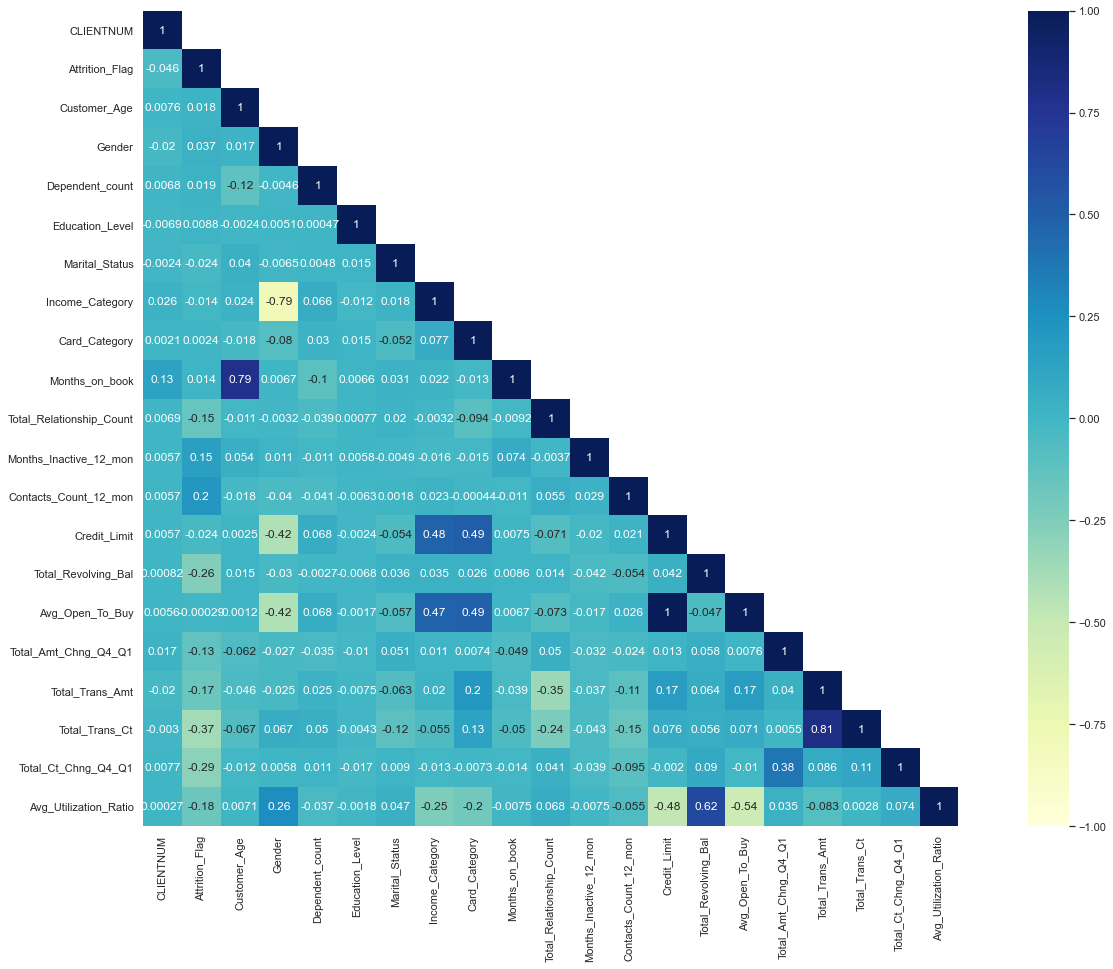

In [551]:
sns.set(style='white')
plt.figure(figsize=(25,15))
mask = np.triu(data_codied.corr(), 1)
dataplot=sns.heatmap(data_codied.corr(),mask=mask,vmax=1, vmin=-1, square=True, cmap='YlGnBu', annot=True)
plt.show()

Na wykresie jest przedstawiona macierz korelacji. Za pomocą tego wykresu można zobaczyć, które dane są najbardziej skorelowane między sobą.

Na przykład:
* ilość miesięcy w banku z wiekiem klienta(korelacja wynosi=0.79)
* ilość transakcji i kwota transakcji(0,81)
* balans na karcie kredytowej po wpłacie i współczynnik pokazujący jak klientu idzie spłacanie kredytu(0.62) 


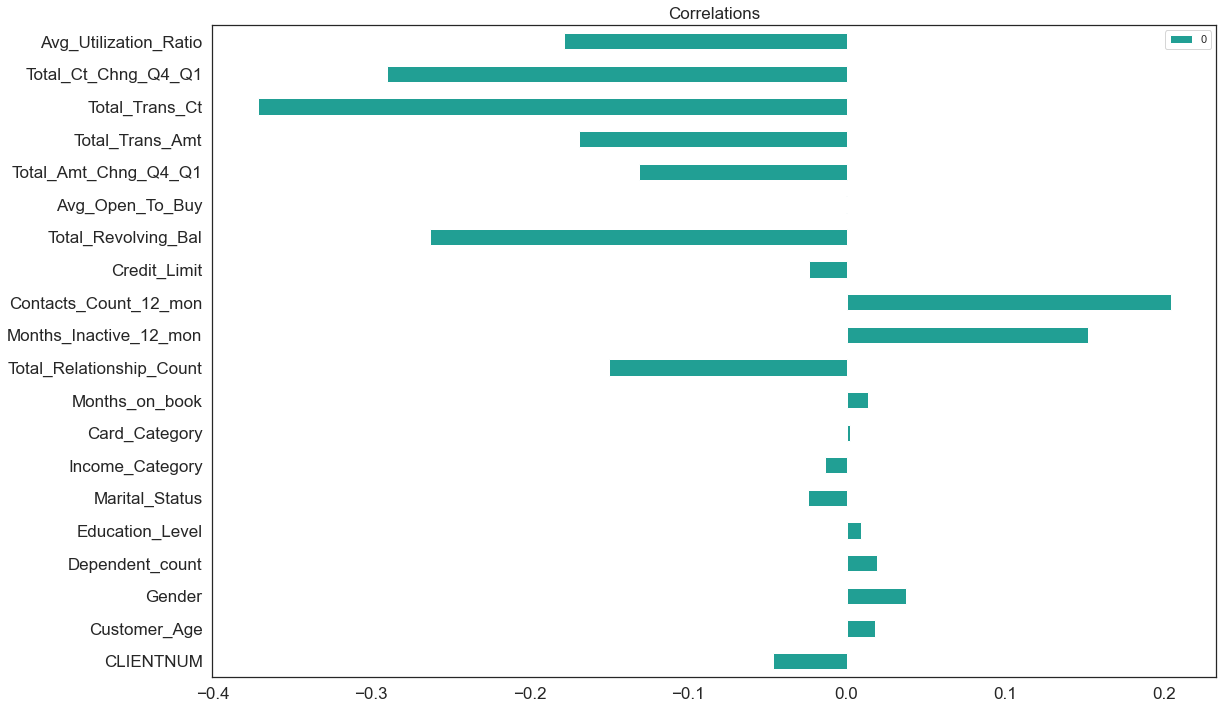

In [552]:
correlation=pd.DataFrame(data_codied.corrwith(data_codied['Attrition_Flag']))

correlation=correlation.drop(["Attrition_Flag"], axis=0)
correlation.plot.barh(
        figsize = (18, 12), 
        fontsize = 17, 
        color = '#219F94')
plt.title("Correlations",fontsize=17)
plt.show()

Wnioski z wykresu:
* na to że klient zmieni bank wpływają kolumny zawierające informację o aktywości klienta i o zgłoszeniach do banku. Wpływ jest przedstawiony w sposób dodatni,czyli im więcej zgłoszeń i im więcej miesięcy bez aktywności, tym bardziej prawdopodonie klient zmieni bank
* natomiast ujemnie skorelowane są wartości występujące w kolumnach Total_Trans_Ct, Total_Ct_Change_Q4_Q1, Total_Trans_Amt, Total_Amt_Change_Q4_Q1, Total_Revolving_Bal, Awg_Utilization_Ratio. 
Czyli wraz ze wzrostem wartości w tych kolumnach zmniejsza się prawdobodopieństwo, że klient porzuci bank


1) im więcej miesięcy klient nie jest aktywny i im częściej zgłasza się do banku, to tym większa jest szansa, że zmieni bank 


2) Wraz ze wzrostem:

-ilości transakcji

-zmienności w ilościach transakcji

-kwot transakcji i ich zmienności

-nie spłaconej kwoty na karcie kredytowej

-pogorszenia sytuacji klienta w spłacaniu kredytu,

zwiększa się prawdopodobieństwo, że klient zostanie w banku



Chcę rozdzielić dane na poszczególne klastry do tego potrzebuję StandardScaler(), żeby wyniki mojego klastrowania wychodziły czystsze i jaśniejsze.

In [553]:
scaler=StandardScaler()
data_std=scaler.fit_transform(data_codied)
print(data_std)

[[ 0.8028781  -0.4375063  -0.16540558 ... -0.97389518  3.8340026
  -0.77588223]
 [ 2.15686101 -0.4375063   0.33357038 ... -1.35734038 12.60857291
  -0.61627565]
 [-0.68276854 -0.4375063   0.58305837 ... -1.91120566  6.80786367
  -0.99715499]
 ...
 [-0.61437177  2.28568136 -0.29014957 ... -0.20700479  0.44430503
  -0.99715499]
 [-0.58995843  2.28568136 -2.03656544 ... -0.12179474  0.04106963
  -0.99715499]
 [-0.67314507  2.28568136 -0.41489356 ... -0.16439977 -0.26555729
  -0.31157218]]


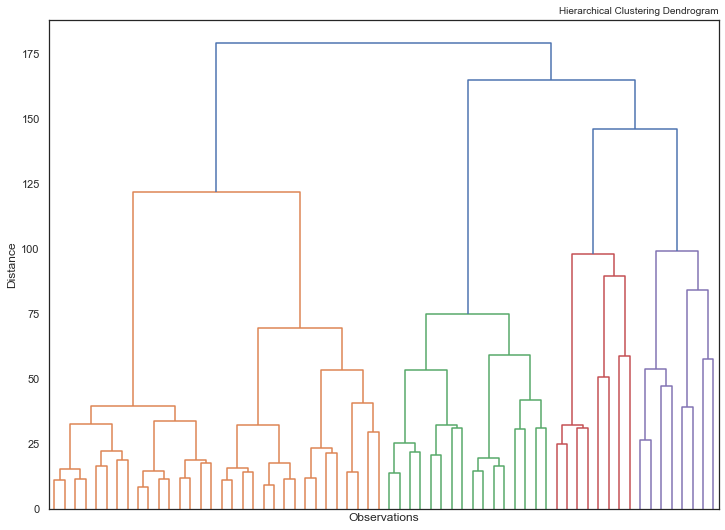

In [554]:
hier_clust = linkage(data_std, metric = "euclidean", method = "ward")
plt.figure(figsize= (12, 9))
plt.title("Hierarchical Clustering Dendrogram", fontsize=10, loc='right')
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hier_clust, truncate_mode = "level", p = 5, show_leaf_counts = False, no_labels = True)
plt.show()

Stosujemy wykres hierarchiczny do wyznaczenia ilości klastrów. W tym wykresie za pomocą kolorów widać,że najskuteczniej będzie zastosować 4 klastry.

Sprawdzamy, za pomocą K-średnich czy ilość klustrów się zgadza.

Na początku nie wiadomo na ile klastrów będzie najlepiej podzieleć klastry. Zakładam k=3 i zobaczymy, co z tego wyjdzie.

Będę stosowała metodę łokcia, za pomocą której wyznaczę najlepszą ilość klastrów.

In [555]:
#Uatalam wccs jako pusty list, wccs-odległość euklidusowa od centru, klalstra
wcss=[]
for i in range(1,11):
    kmeans=KMeans(n_clusters=i, init="k-means++", random_state=42)
    kmeans.fit(data_std)
    wcss.append(kmeans.inertia_)

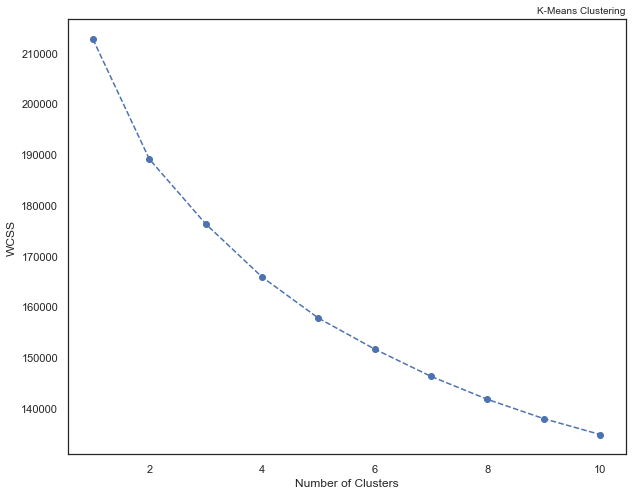

In [556]:
plt.figure(figsize = (10,8))
plt.plot(range(1,11), wcss, marker = "o", linestyle = "--")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.title("K-Means Clustering", fontsize=10, loc='right')
plt.show()

Z wykresu widać,że moment przełomowy następuję w k=4. Dlatego stosujemy taką ilość klastrów do rozdzielania danych.

In [557]:
kmeans = KMeans(n_clusters=4, init="k-means++", random_state=42)
kmeans.fit(data_std)

KMeans(n_clusters=4, random_state=42)

In [558]:
data_km=data_codied.copy()
data_km["Segment K-means"]=kmeans.labels_
data_km_analisys = data_km.groupby(["Segment K-means"]).mean()
data_km_analisys

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
Segment K-means,,,,,,,,,,,,,,,,,,,,,
0,7.354417e+08,0.983039,46.879152,0.642403,2.394346,2.651590,1.897527,1.796466,0.019081,36.450177,...,2.718021,2.990813,5540.095194,597.775972,4942.319223,0.673814,2662.091166,42.732155,0.526893,0.165960
1,7.384297e+08,0.120384,46.151403,0.149926,2.566470,2.600443,1.762925,3.443870,0.558346,35.863368,...,2.306499,2.431315,27563.488183,1188.022895,26375.465288,0.763835,6843.099705,76.362629,0.713453,0.047341
2,7.394705e+08,0.005081,46.405774,0.980370,2.327945,2.602540,1.930947,1.002309,0.014088,35.879908,...,2.284296,2.293764,4371.913764,1256.165589,3115.748176,0.770758,4617.547806,71.042956,0.753690,0.388700
3,7.408390e+08,0.016843,46.031374,0.000330,2.251321,2.578600,2.003633,3.162814,0.000991,35.783025,...,2.261889,2.446830,7703.173976,1282.095443,6421.078534,0.782978,3822.253633,61.211030,0.738979,0.264810


Najbardziej widoczne rozdzielenie  jest w kolumnie, w której zawiera się ilość transakcji wykonanych za ostatnie 12 miesięcy, czyli Total_Trans_Ct. Odwołuje się do tej zmiennej, bo ona jest najbardziej skorelowana i wplywająca na tendecję zmiany banku.

1) 1 klaster będzie z średnią 42,73 tranzakcji

2) 2 klaster z średnią 76,36

3) Z srednią 71,04

4) Z średnią 61,21

In [559]:
data_km_analisys["#_obs"] = data_km[["Segment K-means","Total_Trans_Ct"]].groupby(["Segment K-means"]).count()

data_km_analisys["%_obs"] = data_km_analisys["#_obs"] / data_km_analisys["#_obs"].sum() * 100


data_km_analisys

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,#_obs,%_obs
Segment K-means,,,,,,,,,,,,,,,,,,,,,
0,7.354417e+08,0.983039,46.879152,0.642403,2.394346,2.651590,1.897527,1.796466,0.019081,36.450177,...,5540.095194,597.775972,4942.319223,0.673814,2662.091166,42.732155,0.526893,0.165960,1415,13.972549
1,7.384297e+08,0.120384,46.151403,0.149926,2.566470,2.600443,1.762925,3.443870,0.558346,35.863368,...,27563.488183,1188.022895,26375.465288,0.763835,6843.099705,76.362629,0.713453,0.047341,1354,13.370198
2,7.394705e+08,0.005081,46.405774,0.980370,2.327945,2.602540,1.930947,1.002309,0.014088,35.879908,...,4371.913764,1256.165589,3115.748176,0.770758,4617.547806,71.042956,0.753690,0.388700,4330,42.756986
3,7.408390e+08,0.016843,46.031374,0.000330,2.251321,2.578600,2.003633,3.162814,0.000991,35.783025,...,7703.173976,1282.095443,6421.078534,0.782978,3822.253633,61.211030,0.738979,0.264810,3028,29.900267


C:\Users\julka\AppData\Roaming\Python\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


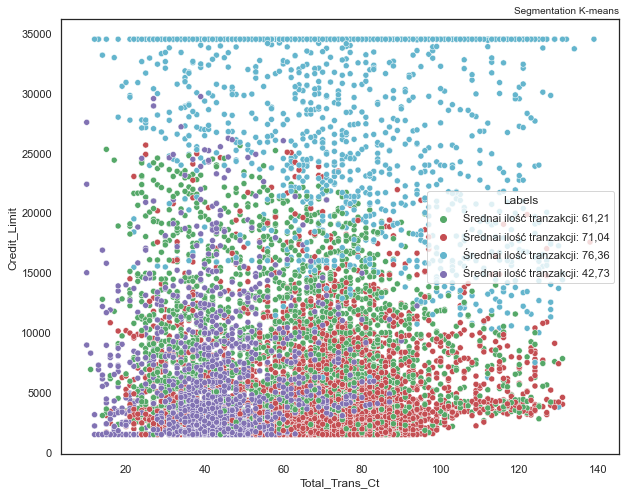

In [560]:
data_km["Labels"] = data_km["Segment K-means"].map({0:"Średnai ilość tranzakcji: 42,73",
                                                1:"Średnai ilość tranzakcji: 76,36",
                                                2:"Średnai ilość tranzakcji: 71,04",
                                                3:"Średnai ilość tranzakcji: 61,21"})
x_axis = data_km["Total_Trans_Ct"]
y_axis = data_km["Credit_Limit"]
plt.figure(figsize = (10, 8))
sns.scatterplot(x_axis, y_axis, hue = data_km["Labels"], palette = ["g", "r", "c", "m"])
plt.title("Segmentation K-means", fontsize=10, loc='right')
plt.show()

W tym przypadku analizy nie skutecznie jest zastosować analizę klastrową. Nie da się tak określić i mieć wniosków z takiego typu analizy w tym przypadku.

In [561]:
data_codied.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,0,45,0,3,2,3,3,0,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,0,49,1,5,4,1,1,0,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,0,51,0,3,4,3,4,0,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,0,40,1,4,2,0,1,0,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,0,40,0,3,1,3,3,0,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


Przed dostosowywaniem danych do modelu, należy sprawdzić, czy występuje współliniowość pomiędzy poszczególnymi wartościami. Dlatego stosuje obliczenie VIF

In [562]:
def calc_vif(x):
    vif=pd.DataFrame()
    vif["variabales"]=x.columns
    vif["VIF"]=[variance_inflation_factor(x.values,i) for i in range(x.shape[1])]
    print(vif)
data_for_vif=data_codied[['Gender','Total_Relationship_Count','Months_Inactive_12_mon',
                          'Contacts_Count_12_mon','Total_Revolving_Bal','Total_Amt_Chng_Q4_Q1',
                          'Total_Trans_Amt','Total_Trans_Ct','Total_Ct_Chng_Q4_Q1','Avg_Utilization_Ratio']]
calc_vif(data_for_vif)
    

                 variabales        VIF
0                    Gender   2.415042
1  Total_Relationship_Count   7.052892
2    Months_Inactive_12_mon   5.532571
3     Contacts_Count_12_mon   5.138744
4       Total_Revolving_Bal   5.315884
5      Total_Amt_Chng_Q4_Q1  13.273713
6           Total_Trans_Amt   8.548007
7            Total_Trans_Ct  21.695576
8       Total_Ct_Chng_Q4_Q1  11.467002
9     Avg_Utilization_Ratio   3.861616


Za pomocą obliczenia VIF możemy zauważyć, że Total_Trans_Ct, Total_Amt_Chng_Q4_Q1, Total_Ct_Chng_Q4_Q1 mają dużą współliniowość.
Zwłaszcza,że z macierzy korealcji powyżej wynika, że total_trans_ct i total_trans_amt są bardzo skorelowane(0.81)

Zobaczymy jak na wykresie się zachowują total_trans_ct i total_ct_chng_q4_q1

Text(0.5, 1.0, 'Korelacja pomiędzy Total_Trans_Amt a Total_Trans_Ct\n')

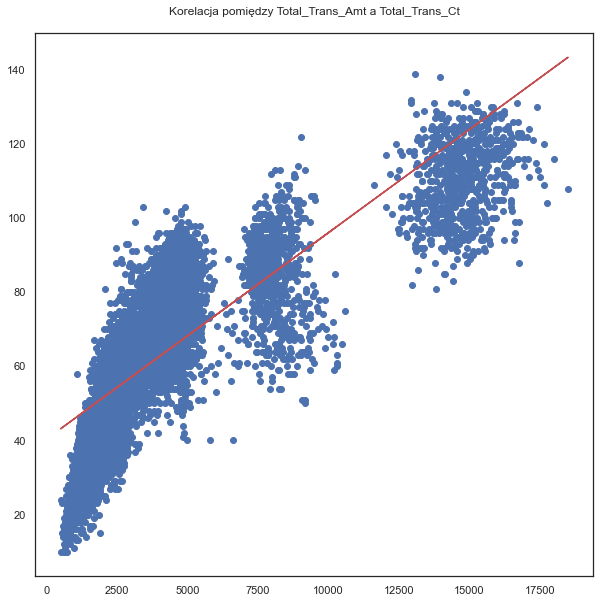

In [563]:
x=data_codied['Total_Trans_Amt']
y=data_codied['Total_Trans_Ct']
a, b =np.polyfit(x,y,1)
plt.figure(figsize=(10,10))
plt.scatter(x, y)
plt.plot(x, a*x+b, 'r-')
plt.title('Korelacja pomiędzy Total_Trans_Amt a Total_Trans_Ct\n')


Skoro te dwie warości są tak mocno skorelowane między sobą, zobaczymy jak będzie zachowywał się vif czyli współczynnik współlinijniści po pozbyciu się kolumny Total_Trans_Amt.

In [564]:
data_for_vif=data_codied[['Gender','Total_Relationship_Count','Months_Inactive_12_mon',
                          'Contacts_Count_12_mon','Total_Revolving_Bal',
                          'Total_Trans_Ct','Total_Ct_Chng_Q4_Q1','Avg_Utilization_Ratio']]
calc_vif(data_for_vif)

                 variabales       VIF
0                    Gender  2.393177
1  Total_Relationship_Count  5.945684
2    Months_Inactive_12_mon  5.409569
3     Contacts_Count_12_mon  4.955767
4       Total_Revolving_Bal  5.208494
5            Total_Trans_Ct  6.923564
6       Total_Ct_Chng_Q4_Q1  8.500620
7     Avg_Utilization_Ratio  3.764779


Jak widać po usunięciu tych warości zmniejszyła się współlinijność, co sprzyja przyszłemu tworzeniu modelu.

Usuwam te wartości z zestawu na którym wykonuję analizę. 

In [565]:
data_codied.drop(['Total_Trans_Amt'], axis=1, inplace=True)
data_codied.drop(['Total_Amt_Chng_Q4_Q1'],axis=1, inplace=True)
print(data_codied.columns.values)

['CLIENTNUM' 'Attrition_Flag' 'Customer_Age' 'Gender' 'Dependent_count'
 'Education_Level' 'Marital_Status' 'Income_Category' 'Card_Category'
 'Months_on_book' 'Total_Relationship_Count' 'Months_Inactive_12_mon'
 'Contacts_Count_12_mon' 'Credit_Limit' 'Total_Revolving_Bal'
 'Avg_Open_To_Buy' 'Total_Trans_Ct' 'Total_Ct_Chng_Q4_Q1'
 'Avg_Utilization_Ratio']


In [566]:
data_codied["Attrition_Flag"].value_counts()
#0 dla klientów którzy zostali
#1 dla tych, którzy zmienili bank

0    8500
1    1627
Name: Attrition_Flag, dtype: int64

Patrząc na te wartości mogę stwierdzić,że dane nie są w balansie

In [567]:
x=data_codied.drop(['Attrition_Flag'], axis=1)
y=data_codied['Attrition_Flag']
#Używam stratify=y, bo dane nie są w balansie
train_x,test_x, train_y, test_y=train_test_split(x, y, stratify=y, test_size=0.2, random_state=0)

print("Number transactions x_train dataset: ", train_x.shape)
print("Number transactions y_train dataset: ", train_y.shape)
print("Number transactions x_test dataset: ", test_x.shape)
print("Number transactions y_test dataset: ", test_y.shape)
#Bardzo ważny krok kopiowanie numerów klientów, przy wyświetleniu wynika do będzie potrzebne
train_id=train_x['CLIENTNUM']
train_x=train_x.drop(['CLIENTNUM'], axis=1)

test_id=test_x['CLIENTNUM']
test_x=test_x.drop(['CLIENTNUM'], axis=1)

Number transactions x_train dataset:  (8101, 18)
Number transactions y_train dataset:  (8101,)
Number transactions x_test dataset:  (2026, 18)
Number transactions y_test dataset:  (2026,)


Już wczęsniej stosowałam StandardScaler i teraz go stosuję na część danych treningowych i testowych.

In [568]:
train_x_std=pd.DataFrame(scaler.fit_transform(train_x))
train_x_std.columns = train_x.columns.values
train_x_std.index = train_x.index.values
train_x = train_x_std

test_x_std=pd.DataFrame(scaler.fit_transform(test_x))
test_x_std.columns = test_x.columns.values
test_x_std.index = test_x.index.values
test_x = test_x_std

Będę stosowała LogisticRegression. Akurat zestaw danych pasuje do tego. 

1-"sukces"(w prawdopodobieństwie) czyli, że klient zmieni bank


0-"porażka" klient zostanie w banku

$$P(Y=1)   funkcji   x$$

In [569]:
logreg=LogisticRegression(random_state = 0)
logreg.fit(train_x, train_y)
y_pred=logreg.predict(test_x)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(test_x, test_y)))

Accuracy of logistic regression classifier on test set: 0.90


Widać,że precyzyjność modelu wynosi 90%

Text(0.5, 12.5, 'Predicted label\n')

<Figure size 2016x1440 with 0 Axes>

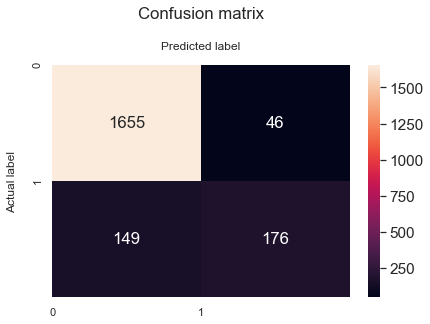

In [570]:
cm = confusion_matrix(test_y, y_pred) 
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (28,20))

# print(confusion_matrix)
fig, ax = plt.subplots()
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, fmt='g'#,cmap="YlGnBu" 
           )
class_names=[0,1]
tick_marks = np.arange(len(class_names))
plt.tight_layout()
plt.title('Confusion matrix\n', y=1.1)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
ax.xaxis.set_label_position("top")
plt.ylabel('Actual label\n')
plt.xlabel('Predicted label\n')

Na wykresie jest przedstawiona confusion matrix czyli macierz błędu. Z powyższej macierzy możemy obliczyć:

1658+177-dobrych przewidzeń 

43+148-złych

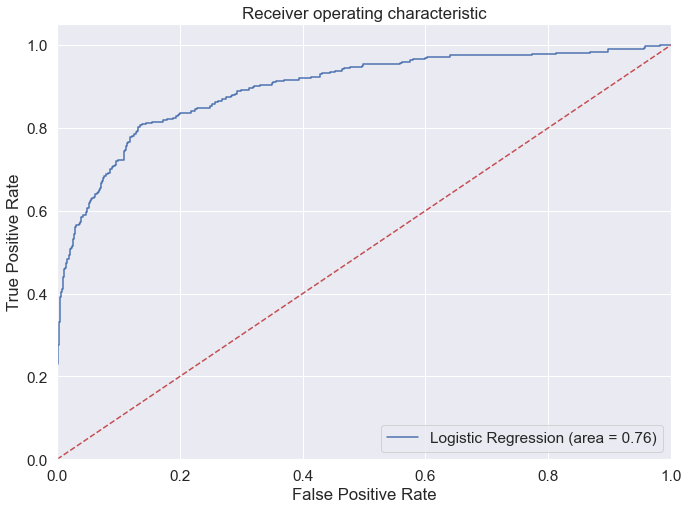

In [571]:
logit_roc_auc = roc_auc_score(test_y, logreg.predict(test_x))
fpr, tpr, thresholds = roc_curve(test_y, logreg.predict_proba(test_x)[:,1])
plt.figure(figsize=(11,8))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Pole pod tą krzywą POC to jest AUC-miara dobroci i trafności danego modelu.
Im to pole będzie większe, tym lepszy będzie model. Dlatego im dalej krzywa wykresu od prostej tym lepiej.  

In [572]:
#tu upewniam się, że wszystkie numery klientów się zahowały 
data_codied['CLIENTNUM']

0        768805383
1        818770008
2        713982108
3        769911858
4        709106358
           ...    
10122    772366833
10123    710638233
10124    716506083
10125    717406983
10126    714337233
Name: CLIENTNUM, Length: 10127, dtype: int64

In [577]:
y_pred_probs = logreg.predict_proba(test_x)
y_pred_probs  = y_pred_probs [:, 1]

In [586]:
final_results = pd.concat([test_id, test_y], axis = 1).dropna()
final_results['predictions'] = y_pred
final_results["probability_to_leave_the_bank"] = y_pred_probs
final_results["probability_to_leave_the_bank"] = final_results["probability_to_leave_the_bank"]*100
final_results["probability_to_leave_the_bank"]=final_results["probability_to_leave_the_bank"].round(2)
final_results = final_results[['CLIENTNUM', 'Attrition_Flag', 'predictions', 'probability_to_leave_the_bank']]

final_results.to_csv('Czy_zmieni_bank.csv')
final_results

,CLIENTNUM,Attrition_Flag,predictions,probability_to_leave_the_bank
8708,712266633,0,0,1.74
9115,708697983,0,0,1.28
1960,772202058,0,0,35.28
6540,721449408,0,0,0.32
9309,716201883,0,0,0.66
...,...,...,...,...
4838,715014633,1,0,11.06
5687,720725883,0,0,4.05
9232,716881683,1,0,25.57
2704,719455908,0,0,10.51


* W kolumnie CLIENTNUM są zawarte numery klientów
* Attrition_Flag: 0-jest klientem banku, 1-zmienił bank
* predictions: przewidywania czy pozostanie w obecnym banku klientem, analogicznie jak w kolumnie Attrition_Flag
* probability_to_leave_the_bank: prawdopobieństwo zajścia "sukcesu", czyli prawdopodobieństwo zmiany banku

### Wnioski:


* zestaw danych był nie zbalansowany pod względem ilości klientów, którzy opuścili bank i tam zostali
* zastosowano metodę kodowania na wartości agregujące
* zastosowano metodę klastrowania i metodę wyznaczania klastów(herachiczną i metodę łokcia)
* wartości, które najbardziej wpływają na podjęcie decyzji o zmianie banku: 

wartości opisujące transakcje wykonane przez klienta,

wraz z opisem przebiegu wpłat pokrywającyh kredyt
* wyliczono współczynnik współliniowości
* jako model zastosowano regresje liniową
* jako efekt końcowy jest przedstawiona tabela w pliku typu csv o nazwie Czy_zmieni_bank.csv
